In [1]:
%matplotlib widget
import numpy as np
import json, copy
import os, math, glob
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [ ]:
pgroup='p19637'
runnumber = 157
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

In [2]:
fc = FileChooser('/sf/alvra/data/p19637/raw')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19637/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
jsonfile = copy.copy(fc.selected)
jsonfile

'/gpfs/photonics/swissfel/raw/alvra/p19637/run0163-Fluence_scan_O_IDTBR_2471p5_5ps/meta/scan.json'

In [6]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_2
detector_Izero = channel_Izero122

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,Izero_pump, Izero_unpump, correlation, waveplate, goodshots) = XAS_scan_1diode(scan, detector_XAS_1, detector_Izero, quantile_corr)


Processing: run0163-Fluence_scan_O_IDTBR_2471p5_5ps
Step 19 of 19: Processing acq0019

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 499 pump and 499 unpump shots
(117,) shots out of (499,) survived
Step 19 of 19: Processed acq0019
correlation Diode (all shots) = 0.9461611159651702


In [7]:
#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
#waveplate2 = 0.12612736 + 66.03399024*(np.cos(np.pi/180.*(waveplate - 60.29428308)))**2

#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
waveplate2 = 0.167279498 + 40.7745686*(np.cos(np.pi/180.*(waveplate - 240.744133)))**2    ##calibration from 3.12 in the night


p1 = 9.24155256  
p2 = 0.16860298 
p3 = 20.65963566 

#intensity = waveplate 
intensity = p2 + p3*(np.cos(2*np.pi/180.*(waveplate - p1)))**2                        ## pulse energy (in uJ)
#intensity = (p2 + p3*(np.cos(2*np.pi/180.*(waveplate - p1)))**2 )*1e-3/(2.45*1e-5)   ## fluence (in mJ/cm2)

In [36]:
p2 + p3*(np.cos(2*np.pi/180.*(52 - p1)))**2     

0.29482896479091436

# Plot Fluence scan

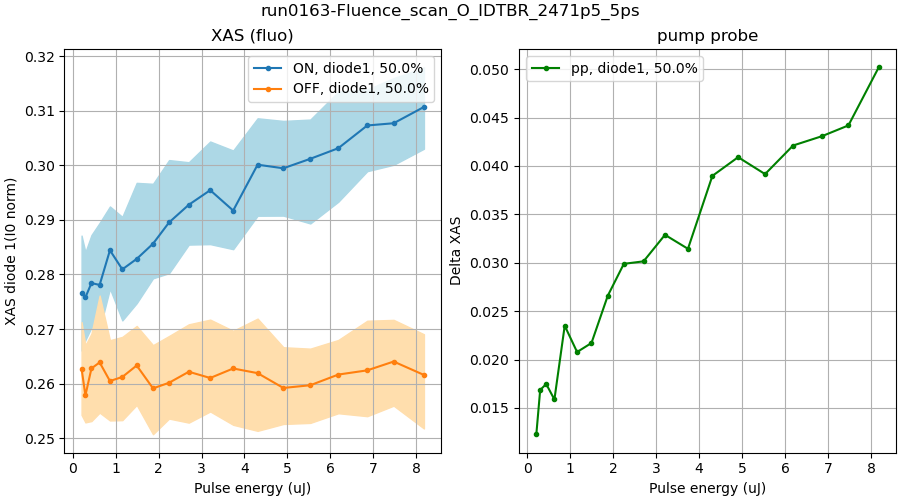

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(intensity, XAS_pump, label='ON, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(intensity, XAS_unpump, label='OFF, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Pulse energy (uJ)")
#ax1.set_xlabel("Fluence (mJ/cm2)")
ax1.set_ylabel ("XAS diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(intensity, XAS_pump_probe, label='pp, diode1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
#ax2.fill_between(intensity, err_low_pump_probe, err_high_pump_probe, color='lightgreen')
#ax2.axes.errorbar(intensity, XAS_pump_probe, (XAS_pump_probe-err_low_pump_probe), (err_high_pump_probe-XAS_pump_probe), 
            # lw=1,color='green', markersize=0,capsize=3,capthick=1,
            #      ecolor='green',elinewidth=1)

ax2.set_xlabel("Pulse energy (uJ)")
#ax2.set_xlabel("Fluence (mJ/cm2)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

# Calculate laser fluence 

In [17]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

[71.4375 70.0875 68.625  67.275  65.8125 64.4625 63.     61.65   60.3
 58.8375 57.4875]
[294.57418891 300.29098644 306.16636561 311.28353047 316.48180893
 320.95006004 325.42117553 329.19748117 332.62831071 335.9463667
 338.63389868]


<IPython.core.display.Javascript object>


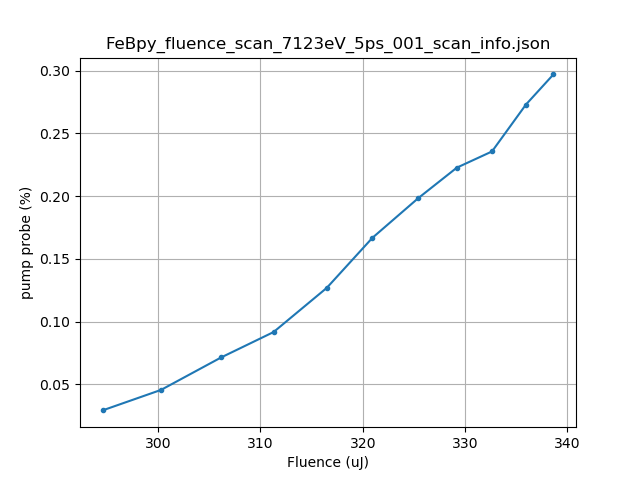

In [20]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(fc.selected.split('/')[-1])
plt.plot(fluences, XAS_pump_probe/XAS_unpump, marker = '.')
plt.grid()
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')
plt.show()